# Segmenting and Clustering Neighborhoods in  Downtown Toronto

## Introduction

In this Notebook, we will explore, segment and cluster the neighborhoods in the city of Toronto downtown. We will use the Foursquare API to explore neighborhoods and use the **explore** function to get the most common venue categories in each neighborhood of downtown Toronto. Using the common venues we will group the neighborhoods into clusters by applying the *k*-means clustering algorithm. We will use the Folium library to visualize the neighborhoods and their clusters in downtown Toronto.

## Table of Contents

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore Neighborhoods in Downtown Toronto</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a> 

Let's import the libraries we will need before we start exploring the data.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Download and Explore Dataset

The neighborhood data is not readily available on the internet. For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. We will scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format.

### Assignment - Part 1

### Downloading Data

Let's download the data and store it in a variable.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
toronto_data = pd.read_html(url,header=0)
toronto_data

[    Postcode           Borough  \
 0        M1A      Not assigned   
 1        M2A      Not assigned   
 2        M3A        North York   
 3        M4A        North York   
 4        M5A  Downtown Toronto   
 5        M5A  Downtown Toronto   
 6        M6A        North York   
 7        M6A        North York   
 8        M7A      Queen's Park   
 9        M8A      Not assigned   
 10       M9A         Etobicoke   
 11       M1B       Scarborough   
 12       M1B       Scarborough   
 13       M2B      Not assigned   
 14       M3B        North York   
 15       M4B         East York   
 16       M4B         East York   
 17       M5B  Downtown Toronto   
 18       M5B  Downtown Toronto   
 19       M6B        North York   
 20       M7B      Not assigned   
 21       M8B      Not assigned   
 22       M9B         Etobicoke   
 23       M9B         Etobicoke   
 24       M9B         Etobicoke   
 25       M9B         Etobicoke   
 26       M9B         Etobicoke   
 27       M1C       

#### Tranform the data into a pandas dataframe

We obtain a list of dataframe objects. Since there is only one object we will just extract that one. Let's have a look at the data.

In [3]:
toronto_data = toronto_data[0]
toronto_data.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


The dataframe contains many cells with a borough that is **Not assigned**. We will drop the rows having *not assigned* values for Borough.

In [4]:
neighborhoods_data = toronto_data[toronto_data.Borough != 'Not assigned']
neighborhoods_data.reset_index(drop=True,inplace=True)
neighborhoods_data.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


Let's check the size of the resulting dataframe.

In [5]:
neighborhoods_data.shape

(211, 3)

We see in the dataframe that more than one neighborhood exist in one postal code area. For example, postal code **M5A** is listed twice and has two neighborhoods: **Harbourfront** and **Regent Park**. Such rows will be combined into one row with the neighborhoods separated with a comma.

In [6]:
neighborhoods_data = neighborhoods_data.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join)
neighborhoods_data = neighborhoods_data.reset_index(level=['Postcode','Borough'])

In [7]:
neighborhoods_data.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Further, if a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough. For example, for row with postal code **M7A**, the value of the Neighborhood columns will be changed to **Queen's Park** since the Borough is **Queen's Park**.

In [8]:
neighborhoods_data['Neighbourhood'].replace('Not assigned',neighborhoods_data.Borough,inplace=True)
neighborhoods_data

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


Finally, let's check the size of the dataframe.

In [9]:
neighborhoods_data.shape

(103, 3)

### Assignment - Part 2

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

#### Use geopy library to get the latitude and longitude values of Toronto.

Let's try using the geocoder package to get the coordinates.

In [10]:
import geocoder
## Commenting out the below code since  not able to get the geographical coordinates of the neighborhoods 
## using the Geocoder package.

'''
geolocator = Nominatim(user_agent="toronto_explorer")
for i,postal_code in zip(neighborhoods_data.index,neighborhoods_data.Postcode):
    address = '{}, Toronto, Ontario'.format(postal_code)
    location = geolocator.geocode(address)
    if location:
        neighborhoods_data.loc[i,'Latitude'] = location.latitude
        neighborhoods_data.loc[i,'Longitude'] = location.longitude
    else:
        neighborhoods_data.loc[i,'Latitude'] = None
        neighborhoods_data.loc[i,'Longitude'] = None

# initialize your variable to None
lat_lng_coords = None

for i,postal_code in zip(neighborhoods_data.index,neighborhoods_data.Postcode):
    address = '{}, Toronto, Ontario'.format(postal_code)
# loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google(address)
        lat_lng_coords = g.latlng
    neighborhoods_data.loc[i,'Latitude'] = lat_lng_coords[0]
    neighborhoods_data.loc[i,'Longitude'] = lat_lng_coords[1]
'''
print('Unable to fetch the coordinates.')

Unable to fetch the coordinates.


Since the coordinates couldn't be obtained, let's download the csv file containing the geographical coordinates of each postal code.

In [11]:
geo_data = pd.read_csv('http://cocl.us/Geospatial_data')
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


We'll rename the column *Postal Code* to *Postcode* so that we can merge the two dataframes easily.

In [12]:
geo_data.rename(columns={'Postal Code':'Postcode'},inplace=True)

Now, let's merge the neighborhoods_data dataframe with the dataframe containing geographical coordinates(geo_data) to obtain the final dataframe.

In [13]:
neighborhoods_toronto = pd.merge(neighborhoods_data,geo_data,on = 'Postcode')
neighborhoods_toronto

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


### Assignment - Part 3

Let's check the number of boroughs in Toronto.

In [14]:
print('The dataframe has {} boroughs.'.format(len(neighborhoods_toronto['Borough'].unique())))

The dataframe has 11 boroughs.


We'll simplify the data further and extract only the neighborhoods containing **Toronto** in their corresponding Borough names.

In [15]:
neighborhoods_toronto = neighborhoods_toronto[neighborhoods_toronto['Borough'].str.contains('Toronto')]
neighborhoods_toronto.reset_index(drop=True,inplace=True)
neighborhoods_toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Let's now check the number of boroughs in our dataframe all containing Toronto in their names.

In [23]:
print('The dataframe has {} boroughs.They are: {}'.format(len(neighborhoods_toronto['Borough'].unique()),list(neighborhoods_toronto['Borough'].unique())))

The dataframe has 4 boroughs.They are: ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']


Let's visualize the boroughs along with neighborhoods superimposed on top in a map of Toronto.

We'll use geopy library to get the latitude and longitude values of Toronto. Also, in order to define an instance of geolocator, we will be defining a user_agent named *toronto_explorer*

In [16]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### Create Toronto neighborhoods map

Next, we'll create the map of Toronto with neighborhoods superimposed on top using the **Folium** library.

Folium is a great visualization library. Feel free to zoom into the below map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

In [18]:
# create map of Toronto using latitude and longitude values
toronto_map = folium.Map(location = [latitude,longitude],zoom_start = 11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_toronto['Latitude'], neighborhoods_toronto['Longitude'], neighborhoods_toronto['Borough'], neighborhoods_toronto['Neighbourhood']):
    label = '[{}], {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

As we saw that there are four unique boroughs containing the word Toronto in their names: ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

Let's segment and cluster only the neighborhoods in **Downtown Toronto** . So let's slice the original dataframe and create a new dataframe of the downtown data.

In [24]:
downtown_data = neighborhoods_toronto[neighborhoods_toronto['Borough']=='Downtown Toronto'].reset_index(drop=True)
downtown_data

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
4,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937
5,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
6,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
7,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
8,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568
9,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752


Let's again visualize the map of toronto with only the neighborhoods of downtown Toronto.

In [25]:
# create map of Toronto using latitude and longitude values
downtown_map = folium.Map(location = [latitude,longitude],zoom_start = 12)

# add markers to map
for lat, lng, label in zip(downtown_data['Latitude'], downtown_data['Longitude'], downtown_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(downtown_map)  
    
downtown_map

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods in Downtown Toronto and segment them.

#### Define Foursquare Credentials and Version

In [26]:
CLIENT_ID = 'KSJB25KBQSV3P00KCLICRIYST2PMTZ4RVQWGJDGWLUEOBJSE' # your Foursquare ID
CLIENT_SECRET = 'ZTI2RGW3KR00KOMYT53LQF1LEWJZBE3DXRMZ4CH5ERRO0QVW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: KSJB25KBQSV3P00KCLICRIYST2PMTZ4RVQWGJDGWLUEOBJSE
CLIENT_SECRET:ZTI2RGW3KR00KOMYT53LQF1LEWJZBE3DXRMZ4CH5ERRO0QVW


Initially, let's just explore the neighborhood with postal code - **M5G**

In [27]:
M5G_latitude = downtown_data.loc[downtown_data['Postcode']=='M5G','Latitude'].values[0]
M5G_longitude = downtown_data.loc[downtown_data['Postcode']=='M5G','Longitude'].values[0]

M5G_neighborhood = downtown_data.loc[downtown_data['Postcode']=='M5G','Neighbourhood'].values[0]
print('Latitude and longitude values of {} are {}, {}.'.format(M5G_neighborhood,M5G_latitude,M5G_longitude))

Latitude and longitude values of Central Bay Street are 43.6579524, -79.3873826.


#### Now, let's get the top 100 venues that are in Central Bay Street within a radius of 500 meters.

First, let's create the GET request URL. We'll name the URL *url*.

In [28]:
radius = 500
LIMIT = 100
url = 'http://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    M5G_latitude, 
    M5G_longitude, 
    radius, 
    LIMIT)
url

'http://api.foursquare.com/v2/venues/explore?&client_id=KSJB25KBQSV3P00KCLICRIYST2PMTZ4RVQWGJDGWLUEOBJSE&client_secret=ZTI2RGW3KR00KOMYT53LQF1LEWJZBE3DXRMZ4CH5ERRO0QVW&v=20180605&ll=43.6579524,-79.3873826&radius=500&limit=100'

Send the GET request and examine the resutls

In [29]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d83e7a2c53093002cbcecae'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 84,
  'suggestedBounds': {'ne': {'lat': 43.6624524045, 'lng': -79.38117421839567},
   'sw': {'lat': 43.6534523955, 'lng': -79.39359098160432}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '537d4d6d498ec171ba22e7fe',
       'name': "Jimmy's Coffee",
       'location': {'address': '82 Gerrard Street W',
        'crossStreet': 'Gerrard & LaPlante',
        'lat': 43.65842123574496,
        'lng': -79.38561319551111,
        'label

Next we'll clean the json and structure it into a pandas dataframe.

In [35]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)
nearby_venues

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-537d4d6d498ec171ba22e7fe-0,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",537d4d6d498ec171ba22e7fe,82 Gerrard Street W,CA,Toronto,Canada,Gerrard & LaPlante,...,"[{'label': 'display', 'lat': 43.65842123574496...",43.658421,-79.385613,NaN,M5G 1Z4,ON,Jimmy's Coffee,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-557231e3498e540f05f3083c-1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",557231e3498e540f05f3083c,70 Gerrard St West,CA,Toronto,Canada,Bay St,...,"[{'label': 'display', 'lat': 43.65856999999997...",43.658570,-79.385123,NaN,M5G 1J5,ON,Tim Hortons,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5a81ae339deb7d369fa7f146-2,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",5a81ae339deb7d369fa7f146,44 Gerrard St W,CA,Toronto,Canada,Yonge St,...,"[{'label': 'display', 'lat': 43.65883296982352...",43.658833,-79.383684,College Park,M5G,ON,Hailed Coffee,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ab2b0b9f964a520e56b20e3-3,"[{'id': '4bf58dd8d48988d155941735', 'name': 'G...",4ab2b0b9f964a520e56b20e3,35 Elm St.,CA,Toronto,Canada,at Bay St.,...,"[{'label': 'display', 'lat': 43.65747228208784...",43.657472,-79.383524,NaN,M5G 1H1,ON,The Queen and Beaver Public House,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4a8355bff964a520d3fa1fe3-4,"[{'id': '4bf58dd8d48988d110941735', 'name': 'I...",4a8355bff964a520d3fa1fe3,101 College St,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.66039091189854...",43.660391,-79.387664,NaN,M5G,ON,Mercatto,0,[],NaN
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b744336f964a520d8d02de3-5,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",4b744336f964a520d8d02de3,78 Gerrard St W,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65839479027968...",43.658395,-79.385338,NaN,M5G 1J5,ON,Somethin' 2 Talk About,0,[],NaN
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-539c6f13498e06f4cc765165-6,"[{'id': '52e81612bcbc57f1066b79f9', 'name': 'M...",539c6f13498e06f4cc765165,43 Elm St,CA,Toronto,Canada,Bay,...,"[{'label': 'display', 'lat': 43.65739749535259...",43.657397,-79.383761,NaN,M5G 1H1,ON,The Elm Tree Restaurant,0,[],88534436
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4c8facf91664b1f79c90aa2f-7,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",4c8facf91664b1f79c90aa2f,College St.,CA,Toronto,Canada,NaN,...,"[{'label': 'display', 'lat': 43.65975136823981...",43.659751,-79.384911,NaN,NaN,ON,College Park Area,0,[],NaN
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ae7b27df964a52068ad21e3-8,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",4ae7b27df964a52068ad21e3,122 Elizabeth St.,CA,Toronto,Canada,at Dundas St. W,...,"[{'label': 'display', 'lat': 43.65526771691681...",43.655268,-79.385165,NaN,M5G 1P5,ON,Japango,0,[],NaN
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-504bbf2ce4b0168121235cbe-9,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",504bbf2ce4b0168121235cbe,179 Dundas St. W,CA,Toronto,Canada,btwn Centre Ave. & Chestnut St.,...,"[{'label': 'display', 'lat': 43.65515746756124...",43.655157,-79.386501,NaN,M5G 1Z8,ON,Sansotei Ramen 三草亭,0,[],NaN


Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [32]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's extract the relevant information from the dataframe.

In [36]:
# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.distance']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,id,name,categories,lat,lng,distance
0,537d4d6d498ec171ba22e7fe,Jimmy's Coffee,Coffee Shop,43.658421,-79.385613,151
1,557231e3498e540f05f3083c,Tim Hortons,Coffee Shop,43.658570,-79.385123,194
2,5a81ae339deb7d369fa7f146,Hailed Coffee,Coffee Shop,43.658833,-79.383684,313
3,4ab2b0b9f964a520e56b20e3,The Queen and Beaver Public House,Gastropub,43.657472,-79.383524,315
4,4a8355bff964a520d3fa1fe3,Mercatto,Italian Restaurant,43.660391,-79.387664,272


And how many venues were returned by Foursquare?

In [37]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

84 venues were returned by Foursquare.


## 2. Explore Neighborhoods in Downtown Toronto

Let's create a function to repeat the same process to all the neighborhoods in Downtown Toronto.

In [49]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL. We will not use any limit on the number of results
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                'Neighborhood_Latitude', 
                'Neighborhood_Longitude', 
                'Id',
                'Venue', 
                'Venue_Latitude', 
                'Venue_Longitude',
                'Distance',
                'Venue_Category']
    
    return(nearby_venues)

Now we'll write the code to run the above function on each neighborhood and create a new dataframe called downtown_venues.

In [50]:
downtown_venues = getNearbyVenues(names = downtown_data['Neighbourhood'],
                                  latitudes = downtown_data['Latitude'],
                                  longitudes = downtown_data['Longitude'])

Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie


Let's check the size of the resulting downtown_venues dataframe.

In [51]:
print(downtown_venues.shape)
downtown_venues.head()

(1291, 9)


,Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Id,Venue,Venue_Latitude,Venue_Longitude,Distance,Venue_Category
0,Rosedale,43.679563,-79.377529,4bae2150f964a520df873be3,Mooredale House,43.678631,-79.380091,230,Building
1,Rosedale,43.679563,-79.377529,4aff2d47f964a520743522e3,Rosedale Park,43.682328,-79.378934,327,Playground
2,Rosedale,43.679563,-79.377529,4bd777aa5cf276b054639b00,Whitney Park,43.682036,-79.373788,408,Park
3,Rosedale,43.679563,-79.377529,4d0e77df76cc37045715767c,Alex Murray Parkette,43.678300,-79.382773,444,Park
4,Rosedale,43.679563,-79.377529,4ef8f2a3775b54cdb5bdec7c,Milkman's Lane,43.676352,-79.373842,464,Trail


Let's check how many venues were returned for each neighborhood

In [53]:
downtown_venues.groupby('Neighbourhood').count()

,Neighborhood_Latitude,Neighborhood_Longitude,Id,Venue,Venue_Latitude,Venue_Longitude,Distance,Venue_Category
Neighbourhood,,,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55,55,55
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",16,16,16,16,16,16,16,16
"Cabbagetown,St. James Town",46,46,46,46,46,46,46,46
Central Bay Street,84,84,84,84,84,84,84,84
"Chinatown,Grange Park,Kensington Market",100,100,100,100,100,100,100,100
Christie,16,16,16,16,16,16,16,16
Church and Wellesley,90,90,90,90,90,90,90,90
"Commerce Court,Victoria Hotel",100,100,100,100,100,100,100,100


We saw in the map of the downtown neighborhoods that a few neighborhoods were relatively close and hence, overlapping. There is a possibility that there may be duplicate venues returned for more than one neighborhoods. Let's write the function **find_duplicates** to find any such venues. We will use venue id as the unique key and compare the distance parameter to assign venue to the closer neighborhood it belongs to.

In [54]:
def find_duplicates(df):
    id_to_neighborhood = {}
    
    # create dictionary for unique ids with values for all neighborhood,distance tuples
    for venue_id,hood,distance in zip(df['Id'],df['Neighbourhood'],df['Distance']):
        if venue_id not in id_to_neighborhood:
            id_to_neighborhood[venue_id] = [(hood,distance)]
        else:
            id_to_neighborhood[venue_id].append((hood,distance))
    
    final_df = {}
    
    # select the neighborhood with minimum distance value
    for key,value in id_to_neighborhood.items():
        data = min(value,key = lambda x:x[1])
        final_df[key] = data
    final_df = pd.DataFrame.from_dict(final_df,orient = 'index',columns = ['Neighbourhood','Distance'])
    final_df.reset_index(inplace=True)
    final_df.rename(columns={"index":"Id"},inplace=True)
    return final_df 

Now, let's store the distinct venue entries in the final_venues dataframe.

In [55]:
final_venues = find_duplicates(downtown_venues)
final_venues.head()

,Id,Neighbourhood,Distance
0,4bae2150f964a520df873be3,Rosedale,230
1,4aff2d47f964a520743522e3,Rosedale,327
2,4bd777aa5cf276b054639b00,Rosedale,408
3,4d0e77df76cc37045715767c,Rosedale,444
4,4ef8f2a3775b54cdb5bdec7c,Rosedale,464


Now, let's merge the dataframe with distinct venue entries(final_venues) back with the downtown_venues dataframe to get all the relevant information in one dataframe.

In [58]:
# List of the columns needed in the final dataframe.
cols = ['Id','Neighbourhood','Neighborhood_Latitude','Neighborhood_Longitude','Venue','Venue_Category']
downtown_venues = pd.merge(final_venues,downtown_venues,on=["Id",'Neighbourhood'],how="inner")[cols]
downtown_venues.head()

,Id,Neighbourhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Category
0,4bae2150f964a520df873be3,Rosedale,43.679563,-79.377529,Mooredale House,Building
1,4aff2d47f964a520743522e3,Rosedale,43.679563,-79.377529,Rosedale Park,Playground
2,4bd777aa5cf276b054639b00,Rosedale,43.679563,-79.377529,Whitney Park,Park
3,4d0e77df76cc37045715767c,Rosedale,43.679563,-79.377529,Alex Murray Parkette,Park
4,4ef8f2a3775b54cdb5bdec7c,Rosedale,43.679563,-79.377529,Milkman's Lane,Trail


Let's check the total number of venues in our dataframe now.

In [59]:
downtown_venues.shape

(840, 6)

Let's find out how many unique categories can be curated from all the returned venues.

In [60]:
#downtown_venues['Venue Category'].unique().shape[0]
print('There are {} uniques categories.'.format(len(downtown_venues['Venue_Category'].unique())))

There are 209 uniques categories.


## 3. Analyze Each Neighborhood

For each neighbourhood, let's examine the categories of venues returned.
Note that there is a venue category named 'neighborhood' so precaution needs to be taken to not accidentally assign the neighbourhoods of downtown toronto to neighborhood category of venue.

First, let's use one hot encoding to specify the category to which the venue belongs.

In [61]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue_Category']],prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_onehot['Neighbourhood'] = downtown_venues['Neighbourhood']

# move neighborhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [62]:
downtown_onehot.shape

(840, 210)

Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category.

In [63]:
downtown_grouped = downtown_onehot.groupby('Neighbourhood').mean().reset_index()
downtown_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide,King,Richmond",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.016949,0.000000,...,0.000000,0.000000,0.0,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.000000
1,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.125,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Cabbagetown,St. James Town",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Chinatown,Grange Park,Kensington Market",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.010000,0.0,0.000000,0.060000,0.000000,0.040000,0.010000,0.000000,0.000000
6,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Church and Wellesley,0.011111,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.011111,0.000000,...,0.011111,0.000000,0.0,0.000000,0.000000,0.011111,0.011111,0.000000,0.011111,0.011111
8,"Commerce Court,Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.029412,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000
9,"Design Exchange,Toronto Dominion Centre",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.032258,0.000000,...,0.000000,0.000000,0.0,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Let's print each neighborhood along with the top 5 most common venues.

In [64]:
num_top_venues = 5

for hood in downtown_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
         venue  freq
0  Coffee Shop  0.07
1   Steakhouse  0.05
2          Bar  0.05
3       Lounge  0.03
4        Hotel  0.03


----Berczy Park----
              venue  freq
0       Coffee Shop  0.17
1             Hotel  0.17
2  Greek Restaurant  0.17
3            Lounge  0.17
4             Beach  0.17


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3           Airport  0.06
4  Sculpture Garden  0.06


----Cabbagetown,St. James Town----
                venue  freq
0         Coffee Shop  0.09
1          Restaurant  0.07
2                Café  0.07
3  Italian Restaurant  0.04
4              Bakery  0.04


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.15
1      Ice Cream Shop  0.05
2                Café  0.05
3  Italian Restaurant  0.05
4     Bubble Tea Shop  0

#### Let's put that into a pandas dataframe.

First, let's write a function to sort the venues in descending order.

In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [66]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = downtown_grouped['Neighbourhood']

for ind in np.arange(downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Bar,Steakhouse,Sushi Restaurant,Breakfast Spot,Asian Restaurant,Lounge,Hotel,Vegetarian / Vegan Restaurant,Neighborhood
1,Berczy Park,Lounge,Greek Restaurant,Liquor Store,Coffee Shop,Beach,Hotel,Diner,Event Space,Ethiopian Restaurant,Electronics Store
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Coffee Shop,Boutique,Boat or Ferry,Bar,Plane,Sculpture Garden
3,"Cabbagetown,St. James Town",Coffee Shop,Restaurant,Café,Pub,Italian Restaurant,Bakery,Pizza Place,Outdoor Sculpture,Park,Breakfast Spot
4,Central Bay Street,Coffee Shop,Ice Cream Shop,Italian Restaurant,Café,Sandwich Place,Salad Place,Bar,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant
5,"Chinatown,Grange Park,Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Mexican Restaurant,Bakery,Vietnamese Restaurant,Chinese Restaurant,Dumpling Restaurant,Coffee Shop,Dessert Shop
6,Christie,Grocery Store,Café,Park,Italian Restaurant,Restaurant,Athletics & Sports,Diner,Nightclub,Convenience Store,Coffee Shop
7,Church and Wellesley,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Gastropub,Men's Store,Gym,Pub,Fast Food Restaurant
8,"Commerce Court,Victoria Hotel",Coffee Shop,Café,Hotel,Fast Food Restaurant,Sandwich Place,Irish Pub,Soup Place,Japanese Restaurant,Beer Bar,Shopping Mall
9,"Design Exchange,Toronto Dominion Centre",Coffee Shop,Restaurant,Italian Restaurant,Hotel,Bakery,Gym,Deli / Bodega,Café,Beer Bar,Spa


Our data is ready for clustering now.

## 4. Cluster Neighborhoods

Run k-means to cluster the neighborhood into clusters.

In [115]:
# set number of clusters
kclusters = 4

downtown_grouped_clustered = downtown_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustered)

# insert generated cluster labels in the dataframe
neighborhoods_venues_sorted.insert(0,'Cluster_Labels',kmeans.labels_)

neighborhoods_venues_sorted.head()

,Cluster_Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Adelaide,King,Richmond",Coffee Shop,Bar,Steakhouse,Sushi Restaurant,Breakfast Spot,Asian Restaurant,Lounge,Hotel,Vegetarian / Vegan Restaurant,Neighborhood
1,2,Berczy Park,Lounge,Greek Restaurant,Liquor Store,Coffee Shop,Beach,Hotel,Diner,Event Space,Ethiopian Restaurant,Electronics Store
2,3,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Coffee Shop,Boutique,Boat or Ferry,Bar,Plane,Sculpture Garden
3,1,"Cabbagetown,St. James Town",Coffee Shop,Restaurant,Café,Pub,Italian Restaurant,Bakery,Pizza Place,Outdoor Sculpture,Park,Breakfast Spot
4,1,Central Bay Street,Coffee Shop,Ice Cream Shop,Italian Restaurant,Café,Sandwich Place,Salad Place,Bar,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant


Let's create a new dataframe that includes the cluster labels as well as the top 10 venues for each neighborhood.

In [116]:
downtown_merged = downtown_data

# merge downtown_merged with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

downtown_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Playground,Trail,Building,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
1,M4X,Downtown Toronto,"Cabbagetown,St. James Town",43.667967,-79.367675,1,Coffee Shop,Restaurant,Café,Pub,Italian Restaurant,Bakery,Pizza Place,Outdoor Sculpture,Park,Breakfast Spot
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Gastropub,Men's Store,Gym,Pub,Fast Food Restaurant
3,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636,1,Coffee Shop,Bakery,Café,Park,Mexican Restaurant,Gym / Fitness Center,Breakfast Spot,Pub,Theater,Cosmetics Shop
4,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Cosmetics Shop,Café,Middle Eastern Restaurant,Tea Room,Ramen Restaurant,Fast Food Restaurant,Sporting Goods Shop,Japanese Restaurant


Let's visualize the resulting clusters.

In [117]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], downtown_merged['Neighbourhood'], downtown_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

#### Cluster 0

In [122]:
downtown_merged.loc[downtown_merged['Cluster_Labels'] == 0, downtown_merged.columns[[2] + list(range(5, downtown_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rosedale,0,Park,Playground,Trail,Building,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### Cluster 1

In [123]:
downtown_merged.loc[downtown_merged['Cluster_Labels'] == 1, downtown_merged.columns[[2] + list(range(5, downtown_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Cabbagetown,St. James Town",1,Coffee Shop,Restaurant,Café,Pub,Italian Restaurant,Bakery,Pizza Place,Outdoor Sculpture,Park,Breakfast Spot
2,Church and Wellesley,1,Coffee Shop,Gay Bar,Japanese Restaurant,Sushi Restaurant,Restaurant,Gastropub,Men's Store,Gym,Pub,Fast Food Restaurant
3,"Harbourfront,Regent Park",1,Coffee Shop,Bakery,Café,Park,Mexican Restaurant,Gym / Fitness Center,Breakfast Spot,Pub,Theater,Cosmetics Shop
4,"Ryerson,Garden District",1,Clothing Store,Coffee Shop,Cosmetics Shop,Café,Middle Eastern Restaurant,Tea Room,Ramen Restaurant,Fast Food Restaurant,Sporting Goods Shop,Japanese Restaurant
5,St. James Town,1,Coffee Shop,Restaurant,Italian Restaurant,Gastropub,Japanese Restaurant,Breakfast Spot,Pizza Place,BBQ Joint,Hotel,Park
7,Central Bay Street,1,Coffee Shop,Ice Cream Shop,Italian Restaurant,Café,Sandwich Place,Salad Place,Bar,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant
8,"Adelaide,King,Richmond",1,Coffee Shop,Bar,Steakhouse,Sushi Restaurant,Breakfast Spot,Asian Restaurant,Lounge,Hotel,Vegetarian / Vegan Restaurant,Neighborhood
9,"Harbourfront East,Toronto Islands,Union Station",1,Coffee Shop,Aquarium,Hotel,Scenic Lookout,Brewery,Café,Plaza,Sports Bar,Park,Pizza Place
10,"Design Exchange,Toronto Dominion Centre",1,Coffee Shop,Restaurant,Italian Restaurant,Hotel,Bakery,Gym,Deli / Bodega,Café,Beer Bar,Spa
11,"Commerce Court,Victoria Hotel",1,Coffee Shop,Café,Hotel,Fast Food Restaurant,Sandwich Place,Irish Pub,Soup Place,Japanese Restaurant,Beer Bar,Shopping Mall


#### Cluster 2

In [124]:
downtown_merged.loc[downtown_merged['Cluster_Labels'] == 2, downtown_merged.columns[[2] + list(range(5, downtown_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Berczy Park,2,Lounge,Greek Restaurant,Liquor Store,Coffee Shop,Beach,Hotel,Diner,Event Space,Ethiopian Restaurant,Electronics Store


#### Cluster 3

In [125]:
downtown_merged.loc[downtown_merged['Cluster_Labels'] == 3, downtown_merged.columns[[2] + list(range(5, downtown_merged.shape[1]))]]

,Neighbourhood,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"CN Tower,Bathurst Quay,Island airport,Harbourf...",3,Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Coffee Shop,Boutique,Boat or Ferry,Bar,Plane,Sculpture Garden


To further identify the discriminating venue categories in each cluster, let's visualize each cluster's top 10 categories.

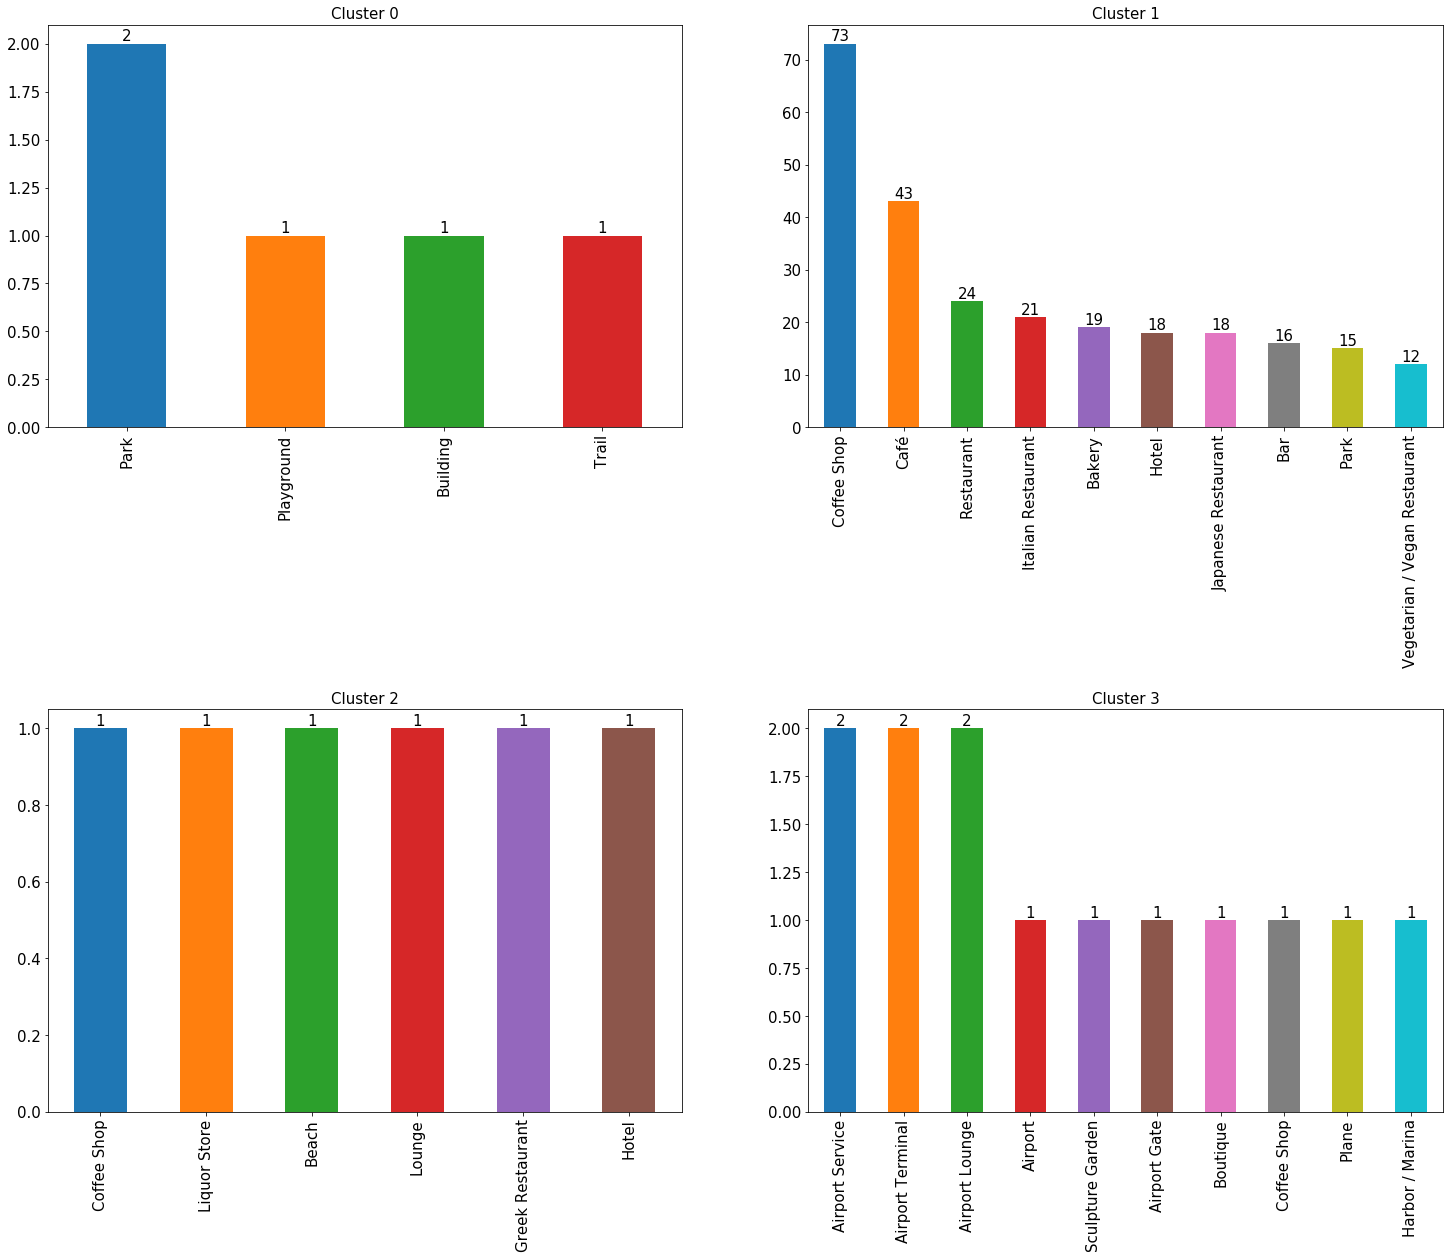

In [128]:
# merge downtown_venues with downtown_merged to add cluster labels with venue categories
downtown_grouped_clustered = pd.merge(downtown_venues,downtown_merged,on="Neighbourhood",how='inner')[['Cluster_Labels','Neighbourhood','Venue','Venue_Category']]

fig,ax = plt.subplots(nrows=2, ncols=2, figsize = (25,20))
plt.subplots_adjust(wspace=0.2, hspace=0.7)
ax = ax.flatten()

for i in range(kclusters):
    data = downtown_grouped_clustered.loc[downtown_grouped_clustered['Cluster_Labels']==i,:]['Venue_Category'].value_counts().head(10)
    data.plot(ax=ax[i],kind='bar',fontsize=15)
    ax[i].set_title('Cluster {}'.format(i),fontsize=15)
    ax[i].set_xticklabels(data.index, rotation='vertical')
    rects = ax[i].patches
    labels = list(data.values)
    for rect,label in zip(rects,labels):
        height = rect.get_height()
        ax[i].text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom',size=15)

plt.show()

Looking at the plots, the clusters can thus be named as:
- Cluster 0: Parks and Recreation Neighborhoods
- Cluster 1: Eating Out/Dining Neighborhoods
- Cluster 2: Coastal Neighborhoods
- Cluster 3: Airport Neighborhoods